In [1]:
import os
from pathlib import Path

if "PROJECT_ROOT" not in globals():
    PROJECT_ROOT = Path.cwd().parent.resolve()

os.chdir(PROJECT_ROOT)

In [2]:
from edit_penalty import EditPenaltyCollection, EditPenaltyCollectionAnalyser
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.transforms import ScaledTranslation
import numpy as np
from numpy import ndarray
import pandas as pd
from pandas import DataFrame, Series
import re
from typing import Iterable, Optional, Tuple, Literal

plt.style.use("ggplot")
plt.style.use("my.mplstyle")

In [44]:
RESULTS_DIR = PROJECT_ROOT/"analysis_results"

LARGELY_SAMPLED_EPITOPES = pd.read_csv("analysis_results/CDR3 Levenshtein/ovr_nn_200_shot.csv").epitope.unique()
LARGELY_SAMPLED_EPITOPES_10X = pd.read_csv("analysis_results/10x/CDR3 Levenshtein/ovr_nn_200_shot.csv").epitope.unique()

NUM_SHOTS_OF_INTEREST = [1,2,5,10,20,50,100,200]

In [4]:
class ModelToPlot:
    def __init__(self, model_name: str, task_prefix: str, colour: Optional[str] = None, marker: str = "", linestyle: str = "-", zorder: Optional[float] = 1.5, ten_x: bool = False) -> None:
        self.name = model_name
        self.task_prefix = task_prefix
        self.colour = colour
        self.marker = marker
        self.linestyle = linestyle
        self.zorder = zorder
        self.ten_x = ten_x
    
    @property
    def style(self) -> str:
        return self.marker + self.linestyle
    
    def load_data(self, k: Optional[int] = None) -> DataFrame:
        if self.task_prefix in ("ovr_nn", "ovr_avg_dist") and k == 1:
            csv_name = f"ovr_1_shot.csv"
        elif self.task_prefix in ("ovr_unseen_epitopes_nn", "ovr_unseen_epitopes_avg_dist") and k == 1:
            csv_name = f"ovr_unseen_epitopes_1_shot.csv"
        elif k is None:
            csv_name = self.task_prefix + ".csv"
        else:
            csv_name = f"{self.task_prefix}_{k}_shot.csv"

        if self.ten_x:
            path_to_csv = RESULTS_DIR/"10x"/self.name/f"{csv_name}"
        else:
            path_to_csv = RESULTS_DIR/self.name/f"{csv_name}"
        
        return pd.read_csv(path_to_csv)
    
    def load_epc_analyser(self) -> EditPenaltyCollectionAnalyser:
        path_to_epc_state_dict = RESULTS_DIR/self.name/"epc_state_dict.pkl"
        with open(path_to_epc_state_dict, "rb") as f:
            epc = EditPenaltyCollection.from_save(f)
        return EditPenaltyCollectionAnalyser(epc)
    
    def get_num_parameters(self) -> int:
        with open(RESULTS_DIR/self.name/"model_parameter_count.txt", "r") as f:
            count = f.read()
            return int(count)

    def get_model_dimensionality(self) -> int:
        with open(RESULTS_DIR/self.name/"model_dimensionality.txt", "r") as f:
            dims = f.read()
            return int(dims)

TASK_PREFIX = Literal["ovr_nn", "ovr_avg_dist", "ovr_svc"]

In [5]:
def generate_summary_figure(
        models: Iterable[ModelToPlot],
        ks: Iterable[int],
        epitopes: Iterable[str],
        legend_in_axes: bool = False,
        ncols: int = 0
) -> Figure:
    fig, ax = plt.subplots(figsize=(8/2.54,6/2.54))

    plot_performance_summary(models, ks, epitopes, ax)
    
    if legend_in_axes:
        ax.legend()
    else:
        fig.legend(loc="upper center", bbox_to_anchor=(0,-0.5,1,0.5), ncols=ncols)
    
    fig.tight_layout()
    
    return fig


def generate_delta_figure(
        anchor_model: ModelToPlot,
        comparison_models: Iterable[ModelToPlot],
        ks: Iterable[int],
        epitopes: Iterable[str],
        ncols: int
) -> Figure:
    fig, ax = plt.subplots(figsize=(8/2.54,6/2.54))

    plot_performance_delta(anchor_model, comparison_models, ks, epitopes, ax, label_lines=True)
    
    fig.legend(loc="center left", bbox_to_anchor=(1, 0, 1, 1), ncols=ncols)
    fig.tight_layout()
    
    return fig


def generate_compound_figure(
        anchor_model: ModelToPlot,
        comparison_models: Iterable[ModelToPlot],
        ks: Iterable[int],
        epitopes: Iterable[str],
        ncols: int
) -> Figure:
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(17/2.54,6/2.54))

    all_models = [anchor_model, *comparison_models]
    plot_performance_summary(all_models, ks, epitopes, axs[0])
    plot_performance_delta(anchor_model, comparison_models, ks, epitopes, axs[1])

    for ax, label in zip(axs, ("a", "b")):
        trans = ScaledTranslation(-50/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')

    fig.legend(loc="upper center", bbox_to_anchor=(0,-0.5,1,0.5), ncols=ncols)
    fig.tight_layout()
    return fig


def plot_performance_summary(
        models: Iterable[ModelToPlot],
        ks: Iterable[int],
        epitopes: Iterable[str],
        ax: Axes
):
    for model in models:
        raw_results = [model.load_data(k) for k in ks]
        average_auc_per_epitope = [df.groupby("epitope").aggregate({"auc": "mean"}) for df in raw_results]
        avg_aucs = [s[s.index.isin(epitopes)].mean().item() for s in average_auc_per_epitope]

        ax.plot(avg_aucs, model.style, c=model.colour, label=model.name, zorder=model.zorder)
    
    ax.set_ylabel("Macro AUROC")
    ax.set_xlabel("Number of Shots")
    ax.set_xticks(range(len(ks)), ks)

    current_min = ax.get_ylim()[0]
    new_min = min(current_min, 0.5)

    ax.set_ylim(new_min)


def plot_performance_delta(
        anchor_model: ModelToPlot,
        comparison_models: Iterable[ModelToPlot],
        ks: Iterable[int],
        epitopes: Iterable[str],
        ax: Axes,
        label_lines: bool = False,
        axis_labels: bool = True
):
    for comparison_model in comparison_models:
        delta, std_delta = compute_delta_estimate_to_anchor(anchor_model, comparison_model, ks, epitopes)
        if label_lines:
            label = comparison_model.name
        else:
            label = None
        ax.errorbar(x=range(len(ks)), y=delta, yerr=std_delta, fmt=comparison_model.style, c=comparison_model.colour, label=label, zorder=comparison_model.zorder, capsize=5)
    
    ax.axhline(y=0, color="white", linewidth=3, zorder=0.1)

    if axis_labels:
        ax.set_ylabel(rf"$\Delta$ Macro AUROC to {anchor_model.name}")
        ax.set_xlabel("Number of Shots")
    
    ax.set_xticks(range(len(ks)), ks)
    

def compute_delta_estimate_to_anchor(
        anchor_model: ModelToPlot,
        comparison_model: ModelToPlot, 
        ks: Iterable[int], 
        epitopes: Iterable[str]
) -> Tuple[ndarray, ndarray]:
    delta, std_delta = [], []

    for k in ks:
        anchor_results = anchor_model.load_data(k)
        comparison_results = comparison_model.load_data(k)
        comparison_results["delta"] = comparison_results["auc"] - anchor_results["auc"]
        comparison_results = comparison_results[comparison_results["epitope"].map(lambda x: x in epitopes)]
        delta_by_epitope = comparison_results.groupby("epitope").apply(
            lambda df: Series(data=(df["delta"].mean(), df["delta"].var()), index=("mean", "var")),
            include_groups=False
        )
        delta_sum, var_delta_sum = delta_by_epitope.sum()
        delta.append(delta_sum / len(delta_by_epitope))
        std_delta.append(np.sqrt(var_delta_sum) / len(delta_by_epitope))

    return np.array(delta), np.array(std_delta)

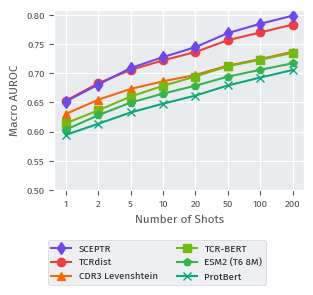

In [6]:
models = (
    ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2),
    ModelToPlot("TCRdist", "ovr_nn", "#f03e3e", "o", zorder=1.9),
    ModelToPlot("CDR3 Levenshtein", "ovr_nn", "#f76707", "^"),
    ModelToPlot("TCR-BERT", "ovr_nn", "#74b816", "s"),
    ModelToPlot("ESM2 (T6 8M)", "ovr_nn", "#37b24d", "p"),
    ModelToPlot("ProtBert", "ovr_nn", "#0ca678", "x"),
)
fig = generate_summary_figure(models, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, ncols=2)
fig.savefig("benchmark_summary.svg", bbox_inches="tight")

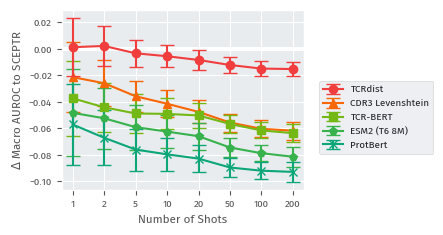

In [7]:
anchor = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2)
comparisons = (
    ModelToPlot("TCRdist", "ovr_nn", "#f03e3e", "o", zorder=1.9),
    ModelToPlot("CDR3 Levenshtein", "ovr_nn", "#f76707", "^"),
    ModelToPlot("TCR-BERT", "ovr_nn", "#74b816", "s"),
    ModelToPlot("ESM2 (T6 8M)", "ovr_nn", "#37b24d", "p"),
    ModelToPlot("ProtBert", "ovr_nn", "#0ca678", "x"),
)
fig = generate_delta_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, ncols=1)
fig.savefig("benchmark_deltas.pdf", bbox_inches="tight")

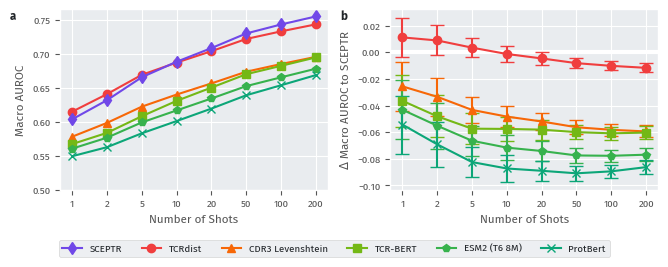

In [10]:
anchor = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2, ten_x=True)
comparisons = (
    ModelToPlot("TCRdist", "ovr_nn", "#f03e3e", "o", zorder=1.9, ten_x=True),
    ModelToPlot("CDR3 Levenshtein", "ovr_nn", "#f76707", "^", ten_x=True),
    ModelToPlot("TCR-BERT", "ovr_nn", "#74b816", "s", ten_x=True),
    ModelToPlot("ESM2 (T6 8M)", "ovr_nn", "#37b24d", "p", ten_x=True),
    ModelToPlot("ProtBert", "ovr_nn", "#0ca678", "x", ten_x=True),
)
fig = generate_compound_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES_10X, ncols=6)
fig.savefig("benchmark_compound_10x.pdf", bbox_inches="tight")

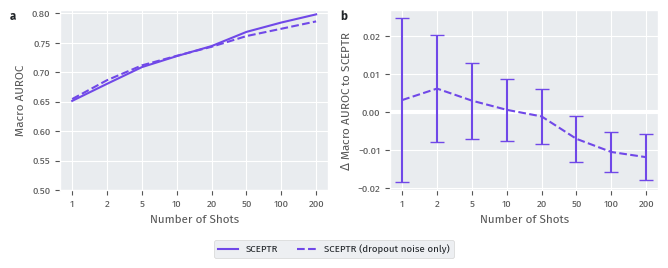

In [11]:
anchor = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8")
comparisons = (
    ModelToPlot("SCEPTR (dropout noise only)", "ovr_nn", "#7048e8", linestyle="--"),
)
fig = generate_compound_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, ncols=6)
fig.savefig("ablation_noising.pdf", bbox_inches="tight")

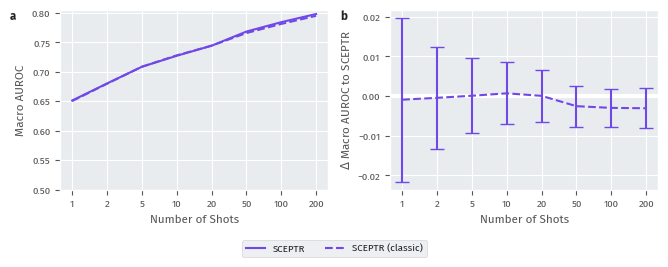

In [12]:
anchor = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8")
comparisons = (
    ModelToPlot("SCEPTR (classic)", "ovr_nn", "#7048e8", linestyle="--"),
)
fig = generate_compound_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, ncols=6)
fig.savefig("simple_vs_classic_embedding.pdf", bbox_inches="tight")

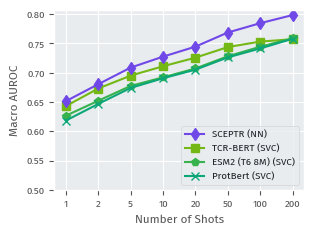

In [13]:
models = (
    ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2),
    ModelToPlot("TCR-BERT", "ovr_svc", "#74b816", "s"),
    ModelToPlot("ESM2 (T6 8M)", "ovr_svc", "#37b24d", "p"),
    ModelToPlot("ProtBert", "ovr_svc", "#0ca678", "x"),
)

fig, ax = plt.subplots(figsize=(8/2.54,6/2.54))

plot_performance_summary(models, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES, ax)

ax.legend(["SCEPTR (NN)", "TCR-BERT (SVC)", "ESM2 (T6 8M) (SVC)", "ProtBert (SVC)"], loc="lower right")

fig.tight_layout()

fig.savefig("svc_benchmark_summary.pdf", bbox_inches="tight")

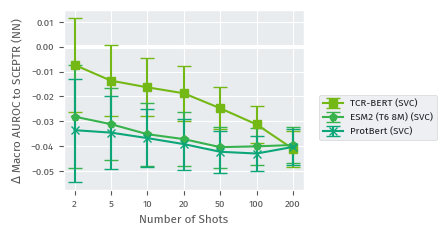

In [14]:
anchor = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2)
comparisons = (
    ModelToPlot("TCR-BERT", "ovr_svc", "#74b816", "s"),
    ModelToPlot("ESM2 (T6 8M)", "ovr_svc", "#37b24d", "p"),
    ModelToPlot("ProtBert", "ovr_svc", "#0ca678", "x"),
)

fig, ax = plt.subplots(figsize=(8/2.54,6/2.54))
plot_performance_delta(anchor, comparisons, NUM_SHOTS_OF_INTEREST[1:], LARGELY_SAMPLED_EPITOPES, ax, label_lines=True)
h, l = ax.get_legend_handles_labels()
fig.legend(h, ["TCR-BERT (SVC)", "ESM2 (T6 8M) (SVC)", "ProtBert (SVC)"], loc="center left", bbox_to_anchor=(1, 0, 1, 1))
ax.set_ylabel(r"$\Delta$ Macro AUROC to SCEPTR (NN)")

fig.tight_layout()

fig.savefig("svc_benchmark_deltas.pdf", bbox_inches="tight")

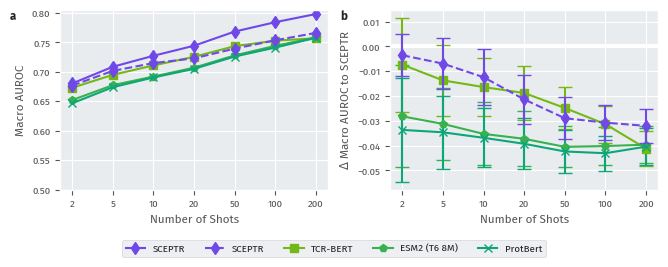

In [45]:
anchor = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2)
comparisons = (
    ModelToPlot("SCEPTR", "ovr_svc", "#7048e8", "d", linestyle="--", zorder=1.9),
    ModelToPlot("TCR-BERT", "ovr_svc", "#74b816", "s"),
    ModelToPlot("ESM2 (T6 8M)", "ovr_svc", "#37b24d", "p"),
    ModelToPlot("ProtBert", "ovr_svc", "#0ca678", "x"),
)

fig = generate_compound_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST[1:], LARGELY_SAMPLED_EPITOPES, ncols=6)


In [15]:
def generate_ablation_figure(ks: Iterable[int], epitopes: Iterable[str]) -> Figure:
    reference_models = [
        ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2),
        ModelToPlot("TCRdist", "ovr_nn", "#f03e3e", "o"),
        ModelToPlot("TCR-BERT", "ovr_nn", "#74b816", "s")
    ]

    mlm_only = ModelToPlot("SCEPTR (MLM only)", "ovr_nn", "#7048e8", linestyle="--")
    avg_pool = ModelToPlot("SCEPTR (average pooling)", "ovr_nn", "#7048e8", linestyle="--")
    shuffled_data = ModelToPlot("SCEPTR (shuffled data)", "ovr_nn", "#7048e8", linestyle="--")
    synthetic_data = ModelToPlot("SCEPTR (synthetic data)", "ovr_nn", "#7048e8", linestyle=":")
    cdr3_only = ModelToPlot("SCEPTR (CDR3 only)", "ovr_nn", "#b197fc")
    cdr3_mlm_only = ModelToPlot("SCEPTR (CDR3 only, MLM only)", "ovr_nn", "#b197fc", linestyle="--")

    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14/2.54,12/2.54))

    def plot_lines(models: Iterable[ModelToPlot], axes: Axes, label_lines: bool) -> None:
        for model in models:
            if label_lines:
                label = model.name
            else:
                label = None

            raw_results = [model.load_data(k) for k in ks]
            average_auc_per_epitope = [df.groupby("epitope").aggregate({"auc": "mean"}) for df in raw_results]
            avg_aucs = [s[s.index.isin(epitopes)].mean().item() for s in average_auc_per_epitope]
            axes.plot(avg_aucs, model.style, c=model.colour, label=label, zorder=model.zorder)

    for ax in axs.flatten():
        plot_lines(reference_models, ax, label_lines=False)
        ax.set_ylim(0.5)

    for ax in axs[1]:
        ax.set_xticks(range(len(ks)), ks)
        ax.set_xlabel("Number of Shots")
    
    for ax in axs[:,0]:
        ax.set_ylabel("Macro AUROC")
    
    plot_lines([mlm_only], axs[0,0], label_lines=True)
    axs[0,0].set_title("Training Ablation")
    axs[0,0].legend(loc="lower right")

    plot_lines([avg_pool], axs[0,1], label_lines=True)
    axs[0,1].set_title("Architectural Ablation")
    axs[0,1].legend(loc="lower right")

    plot_lines([shuffled_data, synthetic_data], axs[1,0], label_lines=True)
    axs[1,0].set_title("Data Ablation")
    axs[1,0].legend(loc="lower right")

    plot_lines([cdr3_only, cdr3_mlm_only], axs[1,1], label_lines=True)
    axs[1,1].set_title("Feature Ablation")
    axs[1,1].legend(loc="lower right")

    for ax, label in zip(axs[:,0], ("a", "c")):
        trans = ScaledTranslation(-50/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')
    
    for ax, label in zip(axs[:,1], ("b", "d")):
        trans = ScaledTranslation(-20/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')

    fig.tight_layout()
    
    custom_lines = [
        Line2D([], [], marker="d", color="#7048e8"),
        Line2D([], [], marker="o", color="#f03e3e"),
        Line2D([], [], marker="s", color="#74b816")
    ]
    
    fig.legend(custom_lines, ["SCEPTR", "TCRdist", "TCR-BERT"], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), ncols=1)

    return fig

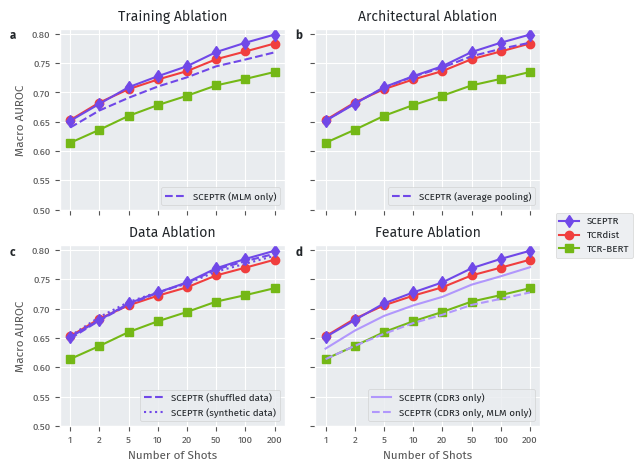

In [16]:
fig = generate_ablation_figure(NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES)
fig.savefig(f"ablation.pdf", bbox_inches="tight")

In [17]:
def generate_ablation_deltas(ks: Iterable[int], epitopes: Iterable[str]) -> Figure:
    sceptr = ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2)
    tcrdist = ModelToPlot("TCRdist", "ovr_nn", "#f03e3e", "o")
    tcrbert = ModelToPlot("TCR-BERT", "ovr_nn", "#74b816", "s")

    mlm_only = ModelToPlot("SCEPTR (MLM only)", "ovr_nn", "#7048e8", linestyle="--")
    avg_pool = ModelToPlot("SCEPTR (average pooling)", "ovr_nn", "#7048e8", linestyle="--")
    shuffled_data = ModelToPlot("SCEPTR (shuffled data)", "ovr_nn", "#7048e8", linestyle="--")
    synthetic_data = ModelToPlot("SCEPTR (synthetic data)", "ovr_nn", "#7048e8", linestyle=":")
    cdr3_only = ModelToPlot("SCEPTR (CDR3 only)", "ovr_nn", "#b197fc")
    cdr3_mlm_only = ModelToPlot("SCEPTR (CDR3 only, MLM only)", "ovr_nn", "#b197fc", linestyle="--")

    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(14/2.54,12/2.54))

    for ax in axs.flatten():
        plot_performance_delta(sceptr, [tcrdist, tcrbert], ks, epitopes, ax, label_lines=False, axis_labels=False)

    for ax in axs[1]:
        ax.set_xticks(range(len(ks)), ks)
        ax.set_xlabel("Number of Shots")
    
    for ax in axs[:,0]:
        ax.set_ylabel("Macro AUROC")
    
    plot_performance_delta(sceptr, [mlm_only], ks, epitopes, axs[0,0], label_lines=True, axis_labels=False)
    axs[0,0].set_title("Training Ablation")
    axs[0,0].legend()

    plot_performance_delta(sceptr, [avg_pool], ks, epitopes, axs[0][1], label_lines=True, axis_labels=False)
    axs[0,1].set_title("Architectural Ablation")
    axs[0,1].legend()

    plot_performance_delta(sceptr, [shuffled_data, synthetic_data], ks, epitopes, axs[1][0], label_lines=True, axis_labels=False)
    axs[1,0].set_title("Data Ablation")
    axs[1,0].legend()

    plot_performance_delta(sceptr, [cdr3_only, cdr3_mlm_only], ks, epitopes, axs[1][1], label_lines=True, axis_labels=False)
    axs[1,1].set_title("Feature Ablation")
    axs[1,1].legend()

    for ax, label in zip(axs[:,0], ("a", "c")):
        trans = ScaledTranslation(-50/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')
    
    for ax, label in zip(axs[:,1], ("b", "d")):
        trans = ScaledTranslation(-20/100, 0, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')

    fig.tight_layout()
    
    custom_lines = [
        Line2D([], [], marker="d", color="#7048e8"),
        Line2D([], [], marker="o", color="#f03e3e"),
        Line2D([], [], marker="s", color="#74b816")
    ]
    
    fig.legend(custom_lines, ["SCEPTR", "TCRdist", "TCR-BERT"], loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), ncols=1)

    return fig

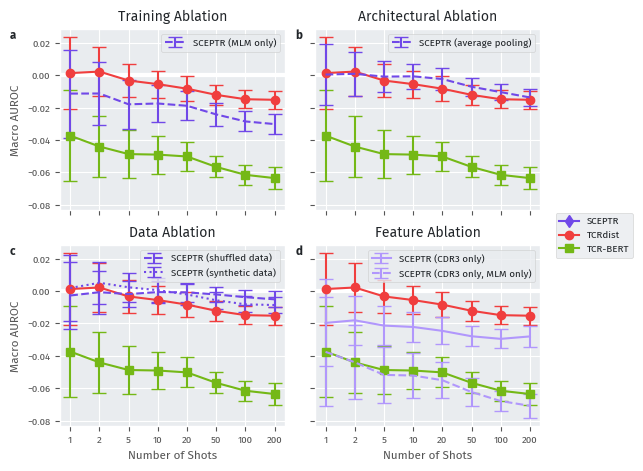

In [18]:
fig = generate_ablation_deltas(NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_EPITOPES)
fig.savefig("ablation_deltas.pdf", bbox_inches="tight")

In [19]:
def plot_predetermined_split_results(models: Iterable[ModelToPlot]) -> Figure:
    aucs_per_model = []

    for model in models:
        aucs_per_model.append(model.load_data().set_index("epitope"))
    
    for model, aucs in zip(models, aucs_per_model):
        aucs.columns = [model.name]
    
    aucs_per_model = pd.concat(aucs_per_model, axis="columns")
    aucs_per_model["avg"] = aucs_per_model.apply(lambda row: row.mean(), axis="columns")
    aucs_per_model = aucs_per_model.sort_values(by="avg", ascending=False)

    fig, ax = plt.subplots(figsize=(8/2.54,8/2.54))

    for model in models:
        ax.plot(aucs_per_model[model.name], model.style, c=model.colour, label=model.name, zorder=model.zorder)

    ax.set_ylabel("AUROC")
    ax.set_xlabel("Epitope")
    ax.tick_params(axis='x', labelrotation=45)

    current_min = ax.get_ylim()[0]
    new_min = min(current_min, 0.5)
    ax.set_ylim(new_min)

    ax.legend()
    fig.tight_layout()

    return fig

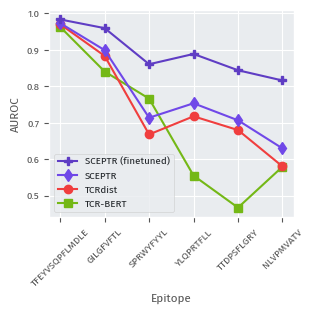

In [20]:
models = (
    ModelToPlot("SCEPTR (finetuned)", "discrimination_ovr_predetermined_split_avg_dist", "#5f3dc4", "P", zorder=2),
    ModelToPlot("SCEPTR", "discrimination_ovr_predetermined_split_nn", "#7048e8", "d", zorder=1.9),
    ModelToPlot("TCRdist", "discrimination_ovr_predetermined_split_nn", "#f03e3e", "o", zorder=1.8),
    ModelToPlot("TCR-BERT", "discrimination_ovr_predetermined_split_nn", "#74b816", "s"),
)

fig = plot_predetermined_split_results(models)
fig.savefig(f"scl_discrimination.pdf", bbox_inches="tight")

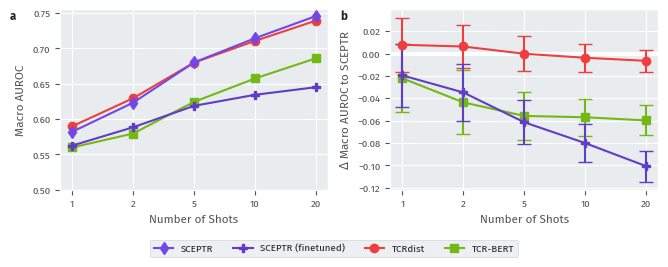

In [21]:
LARGELY_SAMPLED_UNSEEN_EPITOPES = (
    "CINGVCWTV",
    "GLCTLVAML",
    "LLWNGPMAV",
    "ATDALMTGF",
    "QYIKWPWYI",
    "LTDEMIAQY",
)

NUM_SHOTS_OF_INTEREST = [1,2,5,10,20]

anchor = ModelToPlot("SCEPTR", "ovr_unseen_epitopes_nn", "#7048e8", "d", zorder=2)
comparisons = (
    ModelToPlot("SCEPTR (finetuned)", "ovr_unseen_epitopes_avg_dist", "#5f3dc4", "P", zorder=2),
    ModelToPlot("TCRdist", "ovr_unseen_epitopes_nn", "#f03e3e", "o", zorder=1.9),
    ModelToPlot("TCR-BERT", "ovr_unseen_epitopes_nn", "#74b816", "s"),
)

fig = generate_compound_figure(anchor, comparisons, NUM_SHOTS_OF_INTEREST, LARGELY_SAMPLED_UNSEEN_EPITOPES, 4)
fig.savefig(f"scl_does_not_generalise.pdf", bbox_inches="tight")

In [22]:
def plot_model_calibration() -> Figure:
    models = (
        ModelToPlot("SCEPTR", None, None),
        ModelToPlot("TCR-BERT", None, None),
        ModelToPlot("SCEPTR (classic)", None, None),
    )
    epc_insights_per_model = {model.name: model.load_epc_analyser().get_summary_df() for model in models}

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17/2.54,6/2.54), sharex=True)

    position_array = np.arange(5) * 6
    errorbar_kwargs = {
        "fmt": "-",
        "capsize": 3,
    }

    for ax, model_name in zip(axs, epc_insights_per_model):
        epc_insights = epc_insights_per_model[model_name]

        ax.errorbar(position_array, epc_insights["ins"], yerr=epc_insights["ins_std"], label="insertion", c="#7048e8", **errorbar_kwargs)
        ax.errorbar(position_array+1, epc_insights["del"], yerr=epc_insights["del_std"], label="deletion", c="#f76707", **errorbar_kwargs)
        ax.errorbar(position_array+2, epc_insights["sub"], yerr=epc_insights["sub_std"], label="substitution", c="#37b24d", **errorbar_kwargs)
        ax.set_xticks(
            position_array+1, epc_insights.index.str.replace("_","-")
        )

        ax.set_title(model_name)
        ax.set_ylim(0)

    axs[0].set_ylabel("distance")
    axs[1].set_xlabel("CDR3 region")

    for ax, label in zip(axs, ("a", "", "b")):
        trans = ScaledTranslation(-20/100, 20/100, fig.dpi_scale_trans)
        ax.text(0.0, 1.0, label, transform=ax.transAxes + trans, fontsize='large', fontweight="bold", va='top')
    
    fig.legend(*axs[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0,-0.5,1,0.5), ncols=3)
    fig.tight_layout()
    
    return fig

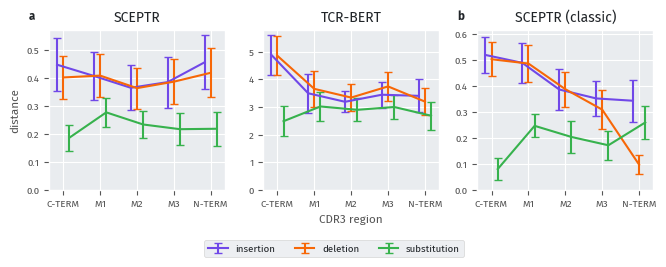

In [23]:
fig = plot_model_calibration()
fig.savefig(f"calibration.pdf", bbox_inches="tight")

In [41]:
def plot_model_complexity(epitopes: Iterable[str]) -> Figure:
    models = [
        ModelToPlot("SCEPTR", "ovr_nn", "#7048e8", "d", zorder=2),
        ModelToPlot("TCR-BERT", "ovr_nn", "#74b816", "s"),
        ModelToPlot("ESM2 (T6 8M)", "ovr_nn", "#37b24d", "p"),
        ModelToPlot("ProtBert", "ovr_nn", "#0ca678", "x"),
    ]

    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8/2.54,5/2.54))

    for model in models:
        num_params = model.get_num_parameters()
        dimensionality = model.get_model_dimensionality()

        aurocs_per_epitope = model.load_data(200).groupby("epitope").aggregate({"auc":"mean"})
        avg_auroc = aurocs_per_epitope[aurocs_per_epitope.index.isin(epitopes)].mean().item()

        axs[0].scatter(num_params, avg_auroc, c=model.colour, marker=model.marker, label=model.name)
        axs[1].scatter(dimensionality, avg_auroc, c=model.colour, marker=model.marker)
    
    axs[0].set_ylabel("200-shot Macro AUROC")
    axs[0].set_ylim(0.5, 0.83)
    axs[0].set_xlim(10**4, 10**9)
    axs[1].set_xlim(10**1, 5*10**3)
    axs[0].set_xlabel("Parameter Count")
    axs[1].set_xlabel("Representation\nDimensionality")
    axs[0].set_xscale("log")
    axs[1].set_xscale("log")

    fig.legend(loc="upper center", bbox_to_anchor=(0,-0.5,1,0.5), ncols=2)
    
    fig.tight_layout()
    return fig

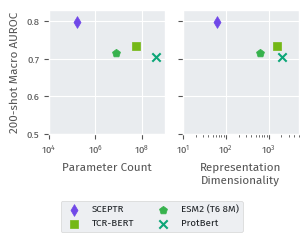

In [42]:
fig = plot_model_complexity(LARGELY_SAMPLED_EPITOPES)
fig.savefig("model_complexity.pdf", bbox_inches="tight")